<a href="https://colab.research.google.com/github/gianpDomiziani/TinyML/blob/main/GAN_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN implementation

In [1]:
import tensorflow as tf

In [2]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-6a2yctu4
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-6a2yctu4
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.00c8dbd4ba403cf3fdd30917f86f817f5228d3812_-cp37-none-any.whl size=147330 sha256=432fe3f22ac7127469cbd1968038f99913e6e33984b250f0333e91416b9b482e
  Stored in directory: /tmp/pip-ephem-wheel-cache-x09xfl57/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [3]:
import keras
from keras import layers
import numpy as np

import matplotlib.pyplot as plt

import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
import time

from IPython import display

In [4]:
LATENT_DIM = 32
HEIGHT = 32
WIDTH = 32
CHANNELS = 3

# Build the generator model

In [5]:
generator_input = keras.Input(shape=(LATENT_DIM,))

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)  # Transform the input into a 16x16x128 feature map

# CONV NET (without Pooling Layers)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)  # Upsamples to 32x32
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(CHANNELS, 7, use_bias=False, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1048576   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024  

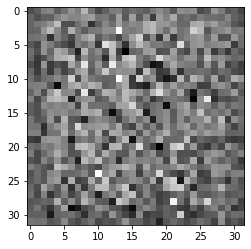

In [6]:
noise = tf.random.normal((1, LATENT_DIM))
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# Build the Discriminator model

In [7]:
discriminator_input = layers.Input(shape=(HEIGHT, WIDTH, CHANNELS))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.3)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         2622

In [8]:
discriminator_optimizer = keras.optimizers.RMSprop(
    learning_rate=0.0008,
    clipvalue=1.0,
    decay=1e-8
)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

# Build the GAN network

In [9]:
discriminator.trainable = False  # set the discriminator weights to not trainable

gan_input = keras.Input(shape=(LATENT_DIM,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

# Implementing GAN training

In [10]:
import os
from keras.preprocessing import image

In [11]:
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

x_train = x_train[y_train.flatten() == 6]  # selects FROG images (class 6)

x_train = x_train.reshape(
    (x_train.shape[0],) +
    (HEIGHT, WIDTH, CHANNELS)).astype('float32') / 255.  # normalizes data 
  
ITERATIONS = 100000
BATCH_SIZE = 256
save_dir = './generated_images'

In [12]:
start = 0
for step in range(ITERATIONS):

  random_latent_vectors = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))  # samples random points in the latent space

  generated_images = generator.predict(random_latent_vectors)  # decodes them to FAKE images

  stop = start + BATCH_SIZE
  real_images = x_train[start: stop]
  combined_images = np.concatenate([generated_images, real_images])

  labels = np.concatenate([np.zeros((BATCH_SIZE, 1)),
                           np.ones((BATCH_SIZE, 1))])
  
  labels += 0.05 * np.random.random(labels.shape)  # adds random noise to the labels (hoping robusteness is reached)

  d_loss = discriminator.train_on_batch(combined_images, labels)

  random_latent_vectors = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))

  misleading_targets = np.ones((BATCH_SIZE, 1))  # assembles target for fooling the discriminator

  a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)  # trains the generator (via the gan model, where the discriminator weights are frozen)

  start += BATCH_SIZE
  if start > len(x_train) - BATCH_SIZE:
    start = 0

  if step % 100 == 0:
    gan.save_weights('gan.h5')
    
    print(f'STEP: {step}')
    print('discriminator loss:', d_loss)
    print('adversial loss:', a_loss)

    img = image.array_to_img(generated_images[0] * 255., scale=False)
    img.save(os.path.join(save_dir,
                          'generated_frog' + str(step) + '.png'))
    
    img = image.array_to_img(real_images[0] * 255., scale=False)
    img.save(os.path.join(save_dir,
                          'real_frog' + str(step) + '.png'))

STEP: 0
discriminator loss: 0.7032589912414551
adversial loss: 0.3455468714237213
STEP: 100
discriminator loss: 4.990224361419678
adversial loss: 0.19758619368076324
STEP: 200
discriminator loss: -0.5396103858947754
adversial loss: 3.0870583624571636e-29
STEP: 300
discriminator loss: -0.23083415627479553
adversial loss: 2.7590572244662326e-06
STEP: 400
discriminator loss: 1.1199439764022827
adversial loss: 1.5416007041931152
STEP: 500
discriminator loss: 0.7323792576789856
adversial loss: 12.047283172607422
STEP: 600
discriminator loss: -1.613619327545166
adversial loss: 0.0
STEP: 700
discriminator loss: -0.7193044424057007
adversial loss: 8.857673645019531
STEP: 800
discriminator loss: -0.26037827134132385
adversial loss: 3.867048740386963
STEP: 900
discriminator loss: 0.23838067054748535
adversial loss: 4.11004114151001
STEP: 1000
discriminator loss: 0.5676189661026001
adversial loss: 0.6532890796661377
STEP: 1100
discriminator loss: 0.6271795034408569
adversial loss: 5.1926507949829

KeyboardInterrupt: ignored